In [1]:
import sys
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm

# Add parent directory to Python path to access src modules
sys.path.append(str(Path("..").resolve()))
from src.geometry.watershed import polygon_area

# Import functions from our organized src modules
from src.meteo.nc_grid import (
    calculate_weighted_meteorology,
    find_extent,
    get_weights,
    nc_by_extent,
)
from src.utils.logger import setup_logger


### Initial Filtering

In [ ]:
# # Load watershed and geometry data from GeoPackage files
# ws_file = gpd.read_file("../data/Geometry/ProperWatersheds2025.gpkg")
# ws_file.set_index("gauge_id", inplace=True)

# geom_file = gpd.read_file("../data/Geometry/ProperPoints2025.gpkg")
# geom_file.set_index("gauge_id", inplace=True)

# # Extract maximum longitude from E-OBS NetCDF file to determine data coverage
# max_lon = get_max_lon_from_netcdf(
#     Path("../data/MeteoData/parsed_meteo/e_obs/rr_ens_mean_0.1deg_reg_2011-2024_v31.0e.nc")
# )

# # Filter watersheds to only include those within E-OBS longitude coverage
# e_obs_ws = filter_watersheds_by_lon(ws_file, max_lon)

# # Filter to gauge IDs with 6 characters or less (specific data quality requirement)
# e_obs_ws = e_obs_ws.loc[e_obs_ws.index.str.len() <= 6]

# # Save filtered watersheds to GeoPackage
# # e_obs_ws.to_file("../data/Geometry/EOBSWatersheds2025.gpkg", driver="GPKG")

# # Extract corresponding gauge points and save them
# e_obs_gauge = geom_file.loc[e_obs_ws.index]
# # e_obs_gauge.to_file("../data/Geometry/EOBSPoints2025.gpkg", driver="GPKG")


### MSWEP daily to by year data

In [2]:
save_folder = Path("../data/MeteoData/parsed_meteo/mswep/total_precipitation/")
save_folder.mkdir(parents=True, exist_ok=True)


def _preprocess(x, lon_bnds, lat_bnds):
    return x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds))


for year in tqdm(range(2017, 2023), desc="Processing MSWEP data"):
    if (save_folder / f"{year}.nc").is_file():
        continue
    mswep_files = list(Path("../data/MeteoData/parsed_meteo/mswep/Daily").glob(f"{year}*.nc"))
    with xr.open_mfdataset(
        mswep_files,
        # preprocess=partial(_preprocess, lon_bnds=(20.0, 50.0), lat_bnds=(70.0, 40.0)),
        parallel=True,
    ) as mswep_year:
        mswep_year = mswep_year.sel(lon=slice(20.0, 50.0), lat=slice(70.0, 40.0))
        mswep_year = mswep_year.sortby("time")
    mswep_year.to_netcdf(save_folder / f"{year}.nc")
    del mswep_year


Processing MSWEP data:   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
with xr.open_mfdataset(
    mswep_files,
    # preprocess=partial(_preprocess, lon_bnds=(20.0, 50.0), lat_bnds=(70.0, 40.0)),
    parallel=True,
) as mswep_year:
    mswep_year = mswep_year.sel(lon=slice(20.0, 50.0), lat=slice(70.0, 40.0))
    mswep_year = mswep_year.sortby("time")
mswep_year

<xarray.Dataset> Size: 131MB
Dimensions:        (time: 365, lat: 300, lon: 300)
Coordinates:
  * lon            (lon) float32 1kB 20.05 20.15 20.25 ... 49.75 49.85 49.95
  * lat            (lat) float32 1kB 69.95 69.85 69.75 ... 40.25 40.15 40.05
  * time           (time) datetime64[ns] 3kB 2014-01-01 ... 2014-12-31
Data variables:
    precipitation  (time, lat, lon) float32 131MB dask.array<chunksize=(1, 24, 16), meta=np.ndarray>
Attributes:
    history:  Created on 2021-02-04 03:16

### Read Geometry Data

In [3]:
# Read watershed and gauge geometry data from GeoPackage files
e_obs_ws = gpd.read_file("../data/Geometry/EOBSWatersheds2025.gpkg", ignore_geometry=False)
e_obs_ws.set_index("gauge_id", inplace=True)
e_obs_gauge = gpd.read_file("../data/Geometry/EOBSPoints2025.gpkg", ignore_geometry=False)
e_obs_gauge.set_index("gauge_id", inplace=True)

In [ ]:
# # Get the bounds of all watersheds in e_obs_ws
# total_bounds = e_obs_ws.total_bounds  # Returns [minx, miny, maxx, maxy]

# # Define E-OBS coverage area based on actual watershed extents
# e_obs_extent = [
#     total_bounds[3],  # N (maxy - northernmost latitude)
#     total_bounds[0],  # W (minx - westernmost longitude)
#     total_bounds[1],  # S (miny - southernmost latitude)
#     total_bounds[2],  # E (maxx - easternmost longitude)
# ]

# print(f"E-OBS coverage extent (N, W, S, E): {e_obs_extent}")

# e_obs_extent = list(map(round, e_obs_extent))  # Convert to integers for plotting
# print(
#     f"Extent bounds: North={e_obs_extent[0]:.3f}, West={e_obs_extent[1]:.3f}, South={e_obs_extent[2]:.3f}, East={e_obs_extent[3]:.3f}"
# )
# e_obs_extent

E-OBS coverage extent (N, W, S, E): [np.float64(69.53791666666666), np.float64(19.917083333333334), np.float64(42.49208333333333), np.float64(45.42958333333334)]
Extent bounds: North=70.000, West=20.000, South=42.000, East=45.000


[70, 20, 42, 45]

### Implement meteorology parser from .nc grid into polygon

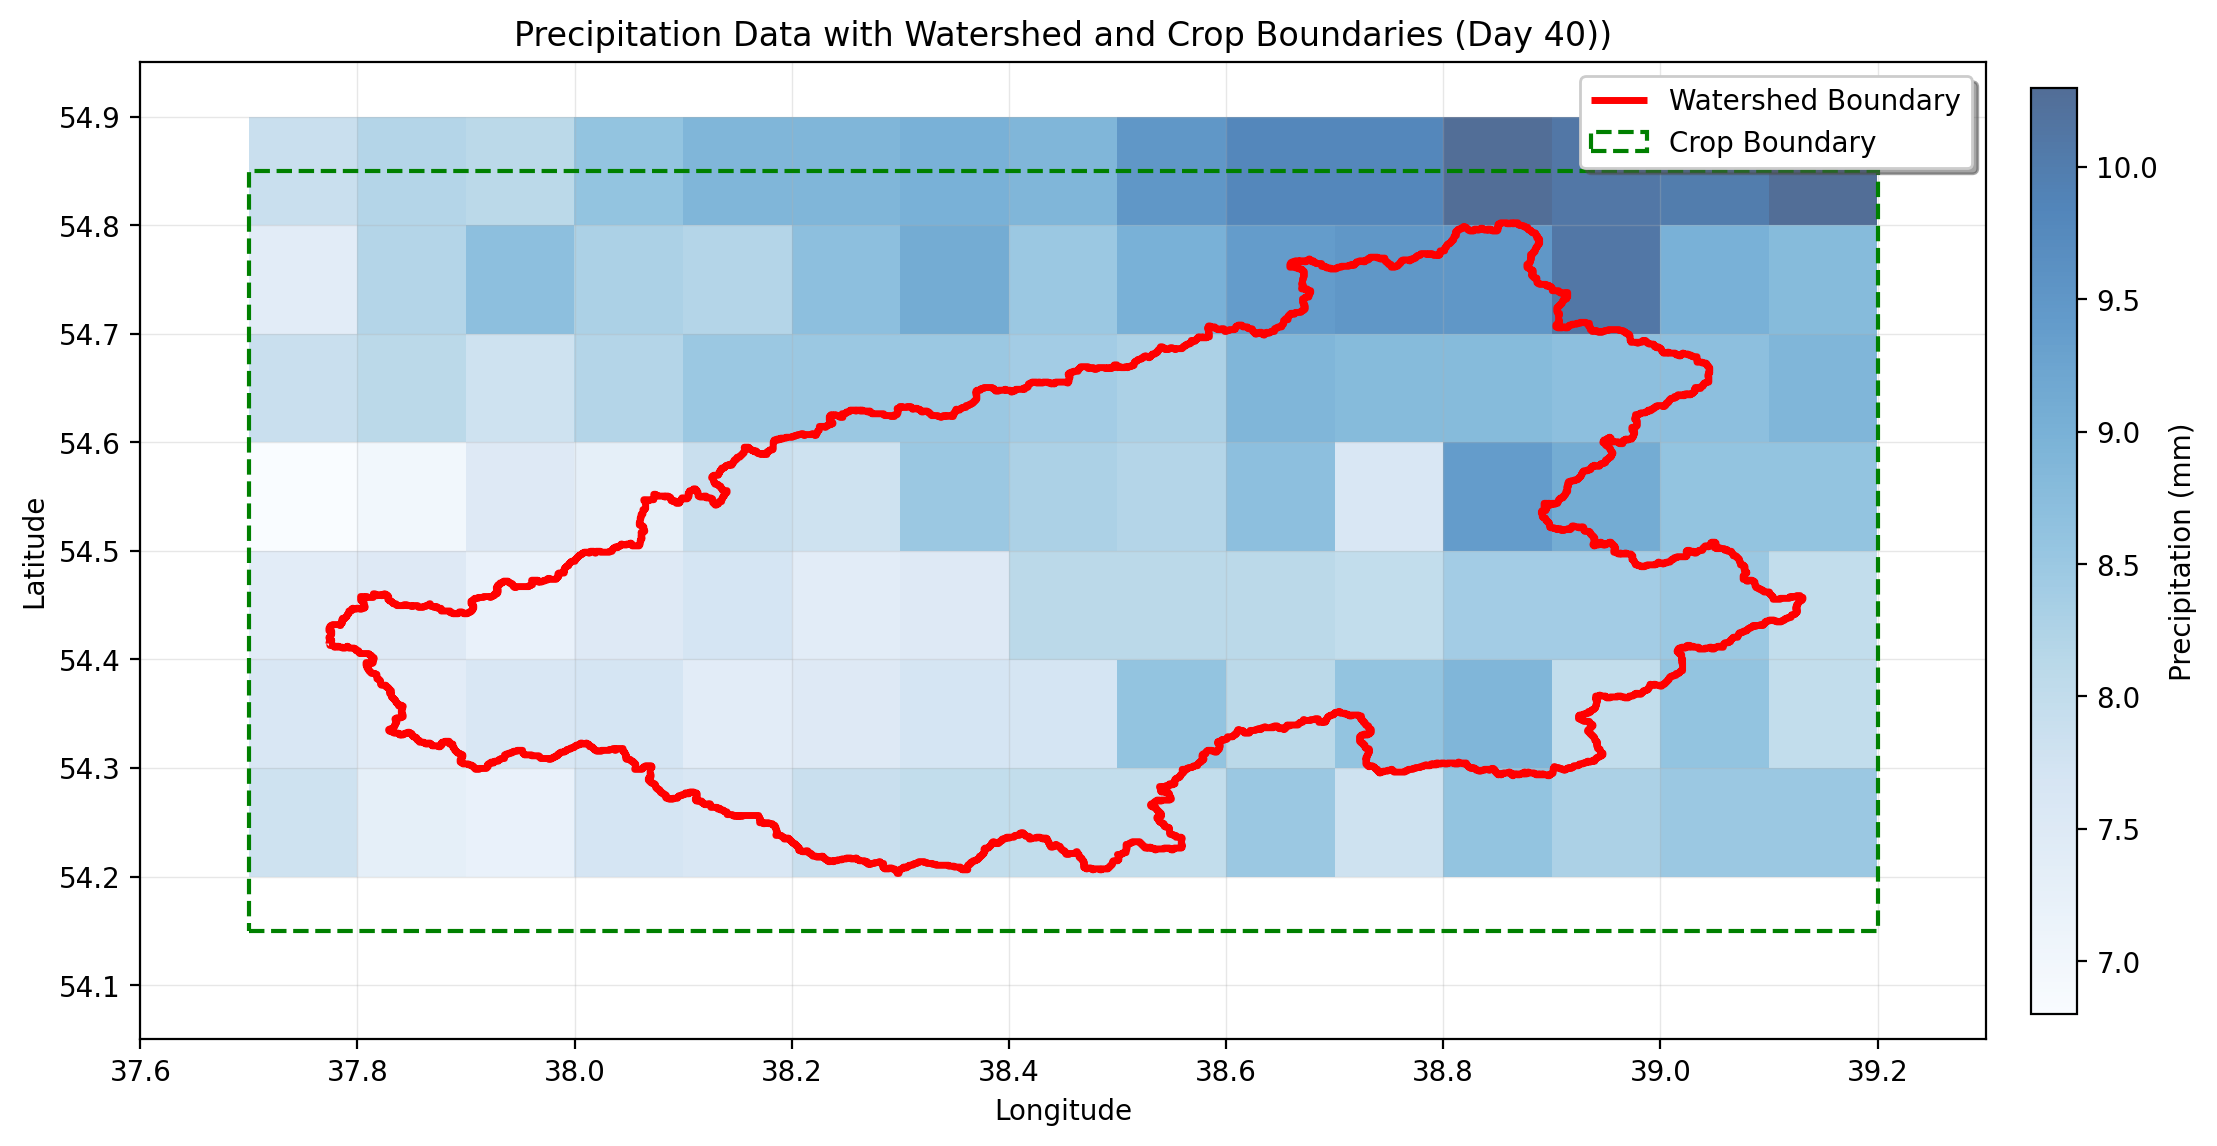

In [9]:
# for each gauge get meteo data
grid_res = 0.05
ws_area = polygon_area(geo_shape=example_geometry)
ws_era5 = nc_by_extent(
    nc=ds,
    shape=example_geometry,
    grid_res=grid_res,
    dataset="era5_land",
)
# Pre-calculate extent values once
crop_extent = find_extent(ws=example_geometry, grid_res=grid_res, dataset="e_obs")
crop_min_lon, crop_max_lon, crop_min_lat, crop_max_lat = crop_extent

# Use constant for buffer to avoid repeated calculations
BUFFER_DEGREES = 0.1
view_extent = [
    crop_min_lon - BUFFER_DEGREES,
    crop_max_lon + BUFFER_DEGREES,
    crop_min_lat - BUFFER_DEGREES,
    crop_max_lat + BUFFER_DEGREES,
]

# Create figure with optimized settings
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

# Plot precipitation data with optimized parameters
precipitation_plot = ws_era5["prcp"][40, :, :].plot(
    ax=ax,
    cmap="Blues",
    alpha=0.7,
    add_colorbar=True,
    cbar_kwargs={"label": "Precipitation (mm)", "shrink": 0.6, "pad": 0.02},
    rasterized=True,  # Optimize for vector output
)

# Create GeoDataFrame more efficiently using existing index
example_gdf = gpd.GeoDataFrame({"gauge_id": [example_id]}, geometry=[example_geometry], crs="EPSG:4326")

# Plot watershed boundary with optimized styling
example_gdf.boundary.plot(
    ax=ax,
    color="red",
    linewidth=2.5,
    label="Watershed Boundary",
    zorder=3,  # Ensure boundary is on top
)

# Create and add crop boundary rectangle
crop_boundary = Rectangle(
    xy=(crop_min_lon, crop_min_lat),
    width=crop_max_lon - crop_min_lon,
    height=crop_max_lat - crop_min_lat,
    linewidth=1.5,
    edgecolor="green",
    facecolor="none",
    linestyle="--",
    label="Crop Boundary",
    zorder=2,
)
ax.add_patch(crop_boundary)

# Set plot properties efficiently
ax.set(
    title="Precipitation Data with Watershed and Crop Boundaries (Day 40))",
    xlabel="Longitude",
    ylabel="Latitude",
    xlim=view_extent[:2],
    ylim=view_extent[2:],
    aspect="equal",
)

# Configure legend and grid
ax.legend(loc="upper right", frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3, linewidth=0.5)

# Optimize layout and display
plt.tight_layout(pad=1.0)
plt.show()


In [ ]:
def standardize_coordinates(ds: xr.Dataset) -> xr.Dataset:
    """Standardize coordinate names to lat/lon if they use alternative names.

    Args:
        ds: Input xarray Dataset

    Returns:
        Dataset with standardized coordinate names
    """
    coord_map = {}
    if "latitude" in ds.coords and "lat" not in ds.coords:
        coord_map["latitude"] = "lat"
    if "longitude" in ds.coords and "lon" not in ds.coords:
        coord_map["longitude"] = "lon"

    if coord_map:
        ds = ds.rename(coord_map)
        ds = ds.sortby("lat", ascending=False)
        return ds
    else:
        ds = ds.sortby("lat", ascending=False)
        return ds


logger = setup_logger(name="MeteoJupyter", log_file="logs/meteo_nc_jupyter.log")

first_year, last_year = 2007, 2022
years = range(first_year, last_year + 1)

magnitude_dict = {"era5_land": 1e2, "e_obs": 1e0, "meteo_ru_nc_02": 1e0, "mswep": 1e0}

dataset = "meteo_ru_nc_02"
grid_res = 0.1  # Define grid resolution for the dataset
magnitude_factor = magnitude_dict[dataset]  # Scale results by the defined factor

variables = (i.stem for i in Path(f"../data/MeteoData/parsed_meteo/{dataset}/").glob("*"))


def yearly_nc(year, dataset):
    """Process and return the NetCDF data for a specific year."""
    nc_files = Path(f"../data/MeteoData/parsed_meteo/{dataset}/").glob(f"*/{year}*.nc")
    if not nc_files:
        logger.error(f"No NetCDF files found for {year} in dataset {dataset}")
        return []
    return list(nc_files)


path_to_results = Path(f"../data/MeteoData/ProcessedGauges/{dataset}/")
path_to_results.mkdir(parents=True, exist_ok=True)
Path(f"{path_to_results}/weights/").mkdir(exist_ok=True, parents=True)

for year in years:
    with xr.open_mfdataset(
        yearly_nc(year, dataset),
        combine="by_coords",
        parallel=True,
    ) as year_ds:
        year_ds = standardize_coordinates(year_ds)
        for gauge_id in tqdm(e_obs_ws.index, desc="Processing gauges", unit=" gauge"):
            ws_geom = e_obs_ws.loc[gauge_id, "geometry"]

            ws_era5 = nc_by_extent(
                nc=year_ds,
                shape=ws_geom,
                grid_res=grid_res,
                dataset=dataset,  # Use the dataset variable instead of hardcoded "era5_land"
            )
            ws_area = polygon_area(geo_shape=ws_geom)

            gauge_weight = Path(f"{path_to_results}/weights/{gauge_id}.nc")

            weights = get_weights(
                weight_path=gauge_weight,
                mask_nc=ws_era5,
                ws_geom=ws_geom,
                ws_area=ws_area,
                grid_res=grid_res,
            )

            # Create intersection mask and filter dataset
            intersection_mask = weights.astype(bool)
            ws_nc = ws_era5.where(intersection_mask, drop=True)

            # Calculate weighted meteorology with magnitude scaling
            res_df = calculate_weighted_meteorology(
                ws_nc=ws_nc,
                weights=weights,
                magnitude_factor=magnitude_factor,
            )

            # Create results directory
            res_path = path_to_results / "res"
            res_path.mkdir(exist_ok=True, parents=True)

            # Add gauge metadata to results
            res_df["gauge_id"] = gauge_id
            res_df["day_of_year"] = pd.to_datetime(res_df.index).dayofyear

            # Convert to xarray and save
            res_df = res_df.to_xarray()
            if (res_path / f"{gauge_id}.nc").is_file():
                with xr.open_dataset(res_path / f"{gauge_id}.nc") as old_file:
                    res_df = res_df.combine_first(old_file)
                res_df.to_netcdf(res_path / f"{gauge_id}.nc")
            else:
                res_df.to_netcdf(res_path / f"{gauge_id}.nc")

            logger.info(f"Processed gauge {gauge_id} successfully")


In [ ]:
with xr.open_mfdataset(
    yearly_nc(year, dataset),
    combine="by_coords",
    parallel=True,
) as year_ds:
    year_ds = standardize_coordinates(year_ds)

ws_geom = e_obs_ws.loc[gauge_id, "geometry"]

ws_era5 = nc_by_extent(
    nc=year_ds,
    shape=ws_geom,
    grid_res=grid_res,
    dataset=dataset,  # Use the dataset variable instead of hardcoded "era5_land"
)
ws_area = polygon_area(geo_shape=ws_geom)

gauge_weight = Path(f"{path_to_results}/weights/{gauge_id}.nc")

weights = get_weights(
    weight_path=gauge_weight,
    mask_nc=ws_era5,
    ws_geom=ws_geom,
    ws_area=ws_area,
    grid_res=grid_res,
)

# Create intersection mask and filter dataset
intersection_mask = weights.astype(bool)
ws_nc = ws_era5.where(intersection_mask, drop=True)

# Calculate weighted meteorology with magnitude scaling
res_df = calculate_weighted_meteorology(
    ws_nc=ws_nc,
    weights=weights,
    magnitude_factor=magnitude_factor,
)


In [20]:
grid_res = 0.05  # Define grid resolution for E-OBS data
example_id = "75394"
example_geometry = e_obs_ws.loc[example_id, "geometry"]

with xr.open_dataset(
    "/home/dmbrmv/Development/MeteoSources/data/MeteoData/parsed_meteo/mswep/total_precipitation/2007.nc"
) as ds:
    pass

ws_era5 = nc_by_extent(
    nc=ds,
    shape=example_geometry,
    grid_res=grid_res,
    dataset="era5_land",
)

ws_area = polygon_area(geo_shape=example_geometry)

e_obs_files = {
    "rr": list(Path("../data/MeteoData/parsed_meteo/e_obs/").glob("rr*.nc")),
    "tn": list(Path("../data/MeteoData/parsed_meteo/e_obs/").glob("tn*.nc")),
    "tx": list(Path("../data/MeteoData/parsed_meteo/e_obs/").glob("tx*.nc")),
}
rename_dict = {
    "rr": "prcp",
    "tn": "t_min",
    "tx": "t_max",
}
path_to_results = Path("../data/MeteoData/ProcessedGauges/e5land")
# Parse .nc data with meteorology onto the watershed polygon with weight of intersection
path_to_results.mkdir(exist_ok=True, parents=True)
# Optimized main processing code
Path(f"{path_to_results}/weights/{grid_res}").mkdir(exist_ok=True, parents=True)
test_weight = Path(f"{path_to_results}/weights/{grid_res}/{example_id}.nc")
if test_weight.exists():
    test_weight.unlink()  # Remove existing file to avoid conflicts
# Get weights with optimized worker count
weights = get_weights(
    weight_path=test_weight,
    mask_nc=ws_era5,
    ws_geom=example_geometry,
    ws_area=ws_area,
    grid_res=grid_res,
    # max_workers=min(mp.cpu_count(), 8),  # Cap workers to avoid overhead
)

# Create intersection mask and filter dataset
intersection_mask = weights.astype(bool)
ws_nc = ws_era5.where(intersection_mask, drop=True)

# Calculate weighted meteorology with magnitude scaling
res_df = calculate_weighted_meteorology(
    ws_nc=ws_nc,
    weights=weights,
    magnitude_factor=1e0,  # Scale results by 100
)
res_df

,prcp
date,
2007-01-01,0.650980
2007-01-02,1.548726
2007-01-03,0.063187
2007-01-04,0.070003
2007-01-05,0.026520
...,...
2007-12-27,0.002991
2007-12-28,0.075638
2007-12-29,0.177445


In [ ]:
res_df.groupby(pd.Grouper(freq="1YE")).sum()

,prcp
date,
2007-12-31,578.637723


In [ ]:
with xr.open_dataset(
    "/home/dmbrmv/Development/MeteoSources/data/MeteoData/ProcessedGauges/Era5Land/res/1001.nc"
) as f:
    pass
f.to_dataframe()

,t_mean,t_min,t_max,prcp,q_cms,q_mm_day,lvl_sm,lvl_mbs,gauge_id,day_of_year,q_cms_s
date,,,,,,,,,,,
2007-01-01,-32.519114,-35.716500,-30.930886,2.484001,NaN,NaN,NaN,NaN,1001,1.0,NaN
2007-01-02,-33.404739,-36.246018,-30.607099,0.369444,NaN,NaN,NaN,NaN,1001,2.0,NaN
2007-01-03,-35.729258,-38.584817,-32.789369,0.134191,NaN,NaN,NaN,NaN,1001,3.0,NaN
2007-01-04,-35.668676,-37.934484,-32.784401,1.241198,NaN,NaN,NaN,NaN,1001,4.0,NaN
2007-01-05,-35.920663,-37.338927,-34.672193,0.476170,NaN,NaN,NaN,NaN,1001,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,-4.641870,-8.299130,-1.389039,2.325571,NaN,NaN,NaN,NaN,1001,117.0,NaN
2025-04-28,-4.610643,-6.662682,-2.375827,6.653284,NaN,NaN,NaN,NaN,1001,118.0,NaN
2025-04-29,-4.578030,-6.708170,-2.510602,7.247389,NaN,NaN,NaN,NaN,1001,119.0,NaN
